In [ ]:
! pip install pandas scikit-learn nltk datasets qalsadi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.6/332.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from datasets import load_dataset
from qalsadi.lemmatizer import Lemmatizer

In [ ]:
# Download NLTK Arabic stopwords
nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load the dataset from Hugging Face
dataset = load_dataset("arbml/Arabic_Sentiment_Twitter_Corpus")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/47000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11751 [00:00<?, ? examples/s]

In [ ]:
# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(dataset['train'])

In [ ]:
# Initialize the stemmer and lemmatizer
stemmer = ISRIStemmer()
lemmatizer = Lemmatizer()


In [ ]:
# Define a function for text segmentation
def segment_text(text):
    # Split the text into segments using punctuation as boundaries
    segments = re.split(r'[.؟!\n]', text)
    return segments


In [ ]:
# Preprocess the text with segmentation, stemming, and lemmatization
def preprocess_text(text):
    # Normalize text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[إأآا]', 'ا', text)
    text = re.sub(r'[ى]', 'ي', text)
    text = re.sub(r'[ؤ]', 'ء', text)
    text = re.sub(r'[ئ]', 'ء', text)
    text = re.sub(r'[\u064B-\u0652]', '', text)  # Remove Arabic diacritics

    # Segment the text
    segments = segment_text(text)

    processed_segments = []
    for segment in segments:
        # Tokenization
        tokens = segment.split()

        # Lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Stemming
        tokens = [stemmer.stem(word) for word in tokens]

        # Stopword removal
        tokens = [word for word in tokens if word not in arabic_stopwords]

        processed_segments.append(' '.join(tokens))

    # Combine the processed segments back into a single string
    return ' '.join(processed_segments)

In [ ]:
df['processed_text'] = df['tweet'].apply(preprocess_text)

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_text'])


In [ ]:
# Label encoding
y = df['label']  # Assuming the label column is 'label'

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Logistic Regression
model = LogisticRegression(max_iter=1000)  # Set the number of iterations here
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

print(f'Accuracy: {accuracy:.2f}')
print(report)

Accuracy: 0.74
              precision    recall  f1-score   support

    Negative       0.73      0.75      0.74      4616
    Positive       0.75      0.73      0.74      4784

    accuracy                           0.74      9400
   macro avg       0.74      0.74      0.74      9400
weighted avg       0.74      0.74      0.74      9400



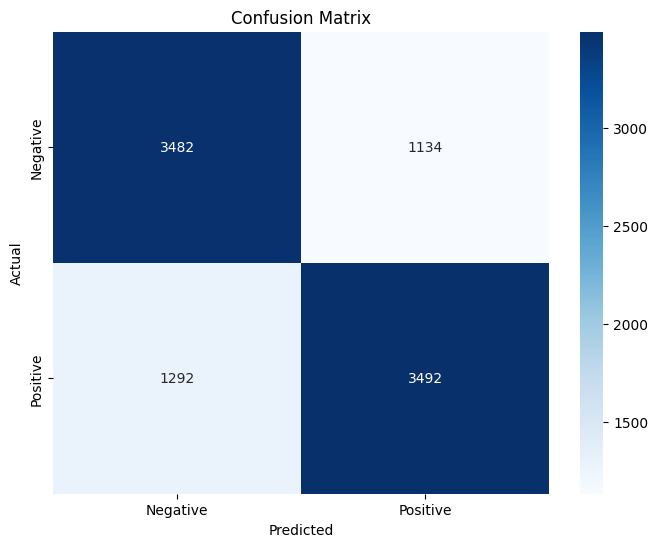

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions for RandomForestClassifier
rf_y_pred = rf_model.predict(X_test)


In [ ]:
# Evaluate the RandomForestClassifier model
accuracy_rf = accuracy_score(y_test, rf_y_pred)
report_rf = classification_report(y_test, rf_y_pred, target_names=['Negative', 'Positive'])

print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print(report_rf)


Random Forest Accuracy: 0.79
              precision    recall  f1-score   support

    Negative       0.77      0.82      0.79      4616
    Positive       0.81      0.76      0.79      4784

    accuracy                           0.79      9400
   macro avg       0.79      0.79      0.79      9400
weighted avg       0.79      0.79      0.79      9400



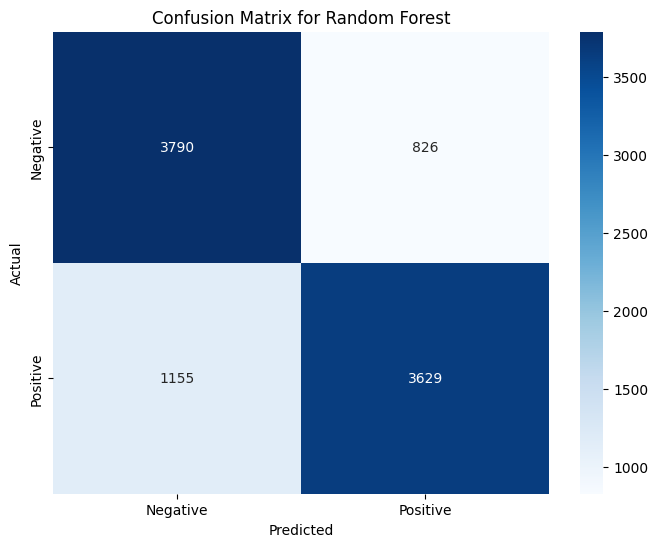

In [ ]:
# Generate confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_y_pred)

# Plot confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()


In [ ]:
! pip install xgboost


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
import xgboost as xgb

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:02:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print("XGBoost:")
print(f'Accuracy: {accuracy_score(y_test, xgb_y_pred):.2f}')
print(classification_report(y_test, xgb_y_pred))

XGBoost:
Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      4616
           1       0.78      0.77      0.77      4784

    accuracy                           0.77      9400
   macro avg       0.77      0.77      0.77      9400
weighted avg       0.77      0.77      0.77      9400



In [ ]:
# Prepare data for LSTM
max_words = 5000
maxlen = 100  # Maximum length of sequences

# Pad sequences for LSTM
X_padded = pad_sequences(X.toarray(), maxlen=maxlen)

# One-hot encode the labels for LSTM
y_one_hot = to_categorical(y)

# Train-test split for LSTM
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_padded, y_one_hot, test_size=0.2, random_state=42)

# Initialize and train LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_words, output_dim=128, input_length=maxlen))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(LSTM(32))
lstm_model.add(LSTM(16))
lstm_model.add(Dense(y_one_hot.shape[1], activation='softmax'))  # Number of classes

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=512, validation_data=(X_test_seq, y_test_seq))

# Predictions
lstm_y_pred = lstm_model.predict(X_test_seq)
lstm_y_pred = lstm_y_pred.argmax(axis=1)  # Convert one-hot to class labels

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5074 - loss: 0.6932 - val_accuracy: 0.4911 - val_loss: 0.6934
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5029 - loss: 0.6933 - val_accuracy: 0.5089 - val_loss: 0.6931
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.5089 - val_loss: 0.6930
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5073 - loss: 0.6931 - val_accuracy: 0.5089 - val_loss: 0.6930
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5033 - loss: 0.6932 - val_accuracy: 0.5089 - val_loss: 0.6930
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5104 - loss: 0.6929 - val_accuracy: 0.5089 - val_loss: 0.6930
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5081 - loss: 0.6931 - val_accuracy: 0.5089 - val_loss: 0.6930
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5095 - loss: 0.6930 - val_accuracy: 0.5089 - val_loss: 0.

In [ ]:
print("LSTM:")
print(f'Accuracy: {accuracy_score(y_test, lstm_y_pred):.2f}')
print(classification_report(y_test, lstm_y_pred))

LSTM:
Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4616
           1       0.51      1.00      0.67      4784

    accuracy                           0.51      9400
   macro avg       0.25      0.50      0.34      9400
weighted avg       0.26      0.51      0.34      9400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
